In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf #Importing the libraries

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
import pathlib

dataset_url = 'https://drive.google.com/drive/folders/1QGOx4H_bQHCdHmmOu2yt8mbmgqe8tMPq'  # Geting the path from the drive
data_dir = tf.keras.utils.get_file('/content/drive/MyDrive/MLPR Images-20240422T103358Z-001/MLPR Images', origin=dataset_url)
data_dir = pathlib.Path(data_dir).with_suffix('')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)    # counting the  total length of the image

1938


In [ ]:
batch_size = 32
# Define image dimensions and batch size
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
# Create training and validation datasets

Found 1938 files belonging to 6 classes.
Using 1551 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1938 files belonging to 6 classes.
Using 387 files for validation.


In [ ]:
class_names = train_ds.class_names # Get class names
print(class_names)

['Background', 'Product_1', 'Product_2', 'Product_3', 'Product_4', 'Product_5']


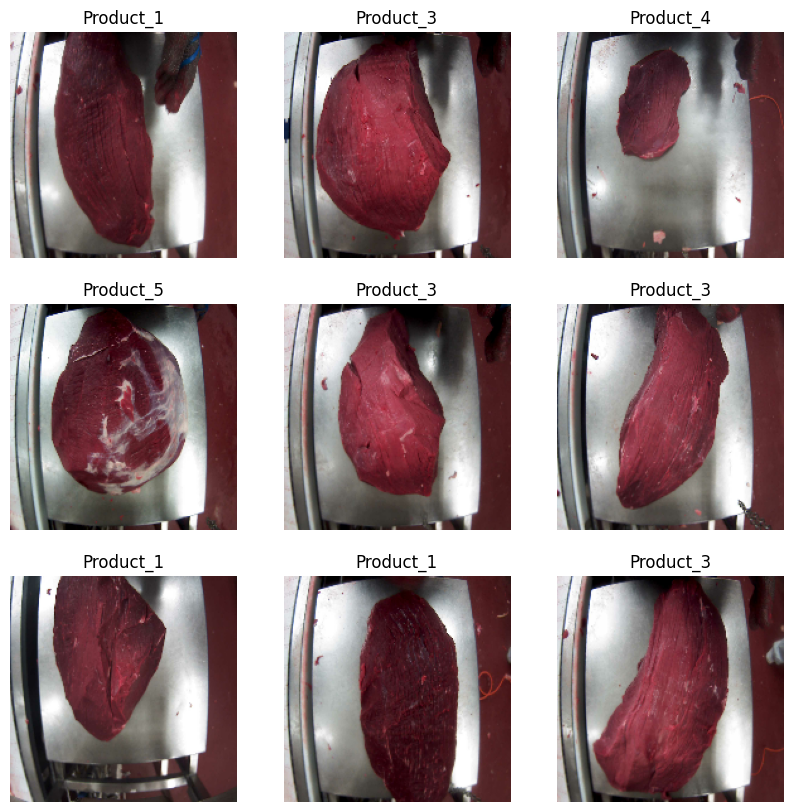

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE # Auto tunning

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
# Create the model
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [ ]:
# Train the model
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)  # Getting the accuracy and validation

Epoch 1/10
49/49 [==============================] - 61s 1s/step - loss: 0.7573 - accuracy: 0.7215 - val_loss: 0.2701 - val_accuracy: 0.9251
Epoch 2/10
49/49 [==============================] - 1s 20ms/step - loss: 0.2496 - accuracy: 0.9226 - val_loss: 0.1686 - val_accuracy: 0.9535
Epoch 3/10
49/49 [==============================] - 1s 21ms/step - loss: 0.1408 - accuracy: 0.9626 - val_loss: 0.1420 - val_accuracy: 0.9612
Epoch 4/10
49/49 [==============================] - 1s 20ms/step - loss: 0.1379 - accuracy: 0.9523 - val_loss: 0.1281 - val_accuracy: 0.9638
Epoch 5/10
49/49 [==============================] - 1s 20ms/step - loss: 0.0540 - accuracy: 0.9845 - val_loss: 0.1237 - val_accuracy: 0.9587
Epoch 6/10
49/49 [==============================] - 1s 20ms/step - loss: 0.0389 - accuracy: 0.9884 - val_loss: 0.1614 - val_accuracy: 0.9612
Epoch 7/10
49/49 [==============================] - 1s 22ms/step - loss: 0.0487 - accuracy: 0.9826 - val_loss: 0.1587 - val_accuracy: 0.9302
Epoch 8/10
49/

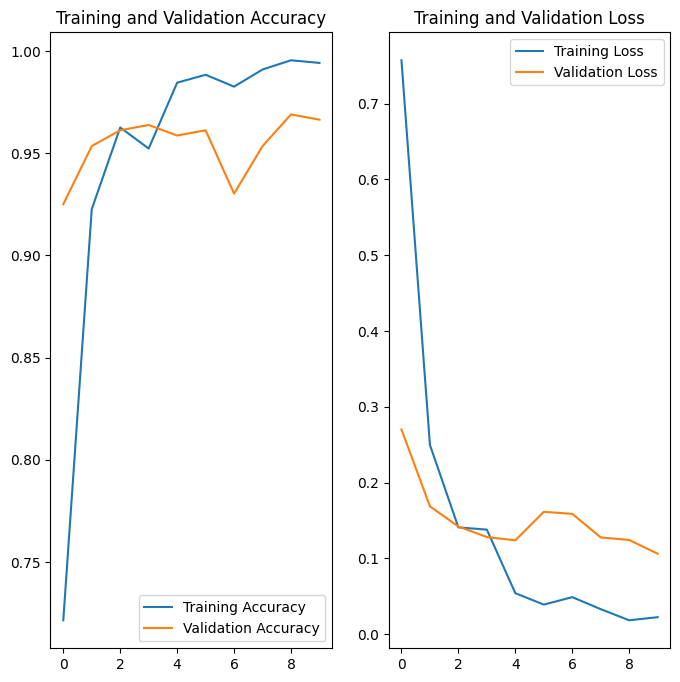

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Data augmentation
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

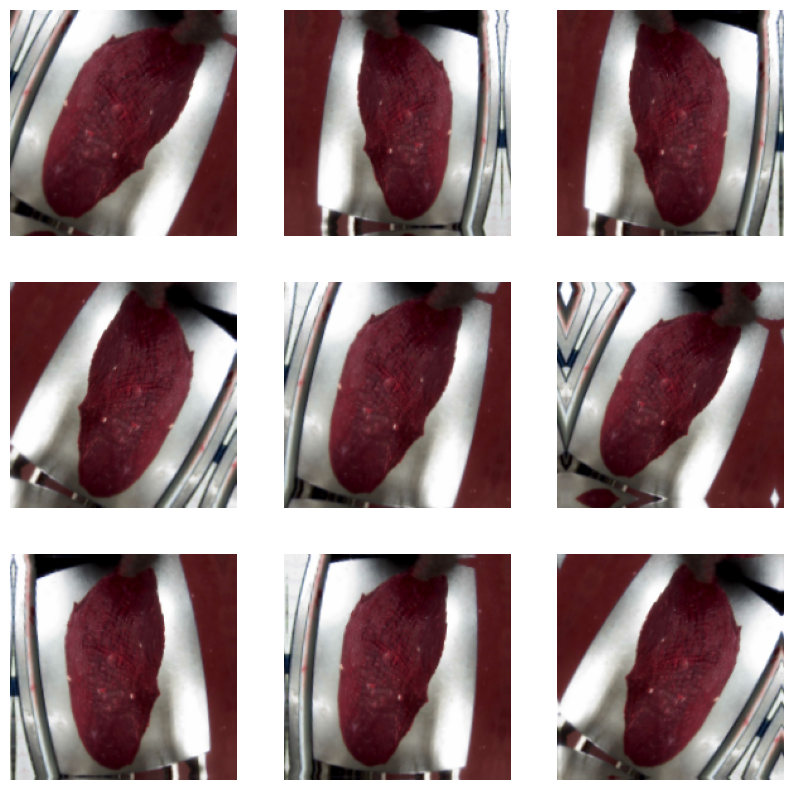

In [ ]:
# Plot training history
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [ ]:
# Train the model
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
49/49 [==============================] - 5s 37ms/step - loss: 1.2364 - accuracy: 0.5113 - val_loss: 0.6996 - val_accuracy: 0.7778
Epoch 2/15
49/49 [==============================] - 2s 32ms/step - loss: 0.4444 - accuracy: 0.8369 - val_loss: 0.2946 - val_accuracy: 0.9147
Epoch 3/15
49/49 [==============================] - 1s 28ms/step - loss: 0.2555 - accuracy: 0.9181 - val_loss: 0.3093 - val_accuracy: 0.8605
Epoch 4/15
49/49 [==============================] - 1s 28ms/step - loss: 0.2232 - accuracy: 0.9265 - val_loss: 0.1327 - val_accuracy: 0.9664
Epoch 5/15
49/49 [==============================] - 1s 28ms/step - loss: 0.2366 - accuracy: 0.9175 - val_loss: 0.1604 - val_accuracy: 0.9535
Epoch 6/15
49/49 [==============================] - 1s 28ms/step - loss: 0.1701 - accuracy: 0.9452 - val_loss: 0.1183 - val_accuracy: 0.9664
Epoch 7/15
49/49 [==============================] - 1s 28ms/step - loss: 0.1608 - accuracy: 0.9491 - val_loss: 0.1365 - val_accuracy: 0.9587
Epoch 8/15
49

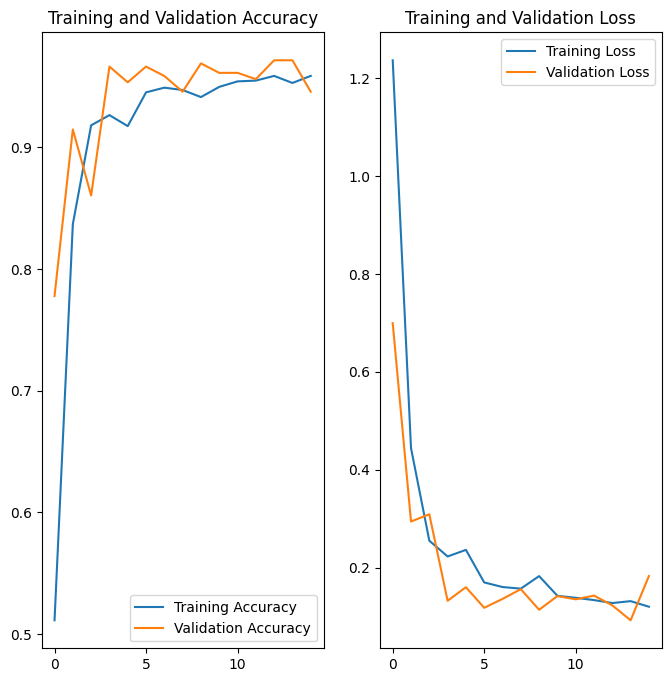

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()